In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_eight_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 7].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_seventh_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 6].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per calcolare l'intervallo di confidenza
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

# Funzione per rimuovere '_vec' dalla fine del nome del file
def remove_vec_suffix(file_name):
    if file_name.endswith('_vec.csv'):
        return file_name[:-8]
    else:
        return file_name

# Funzione per ottenere il numero finale dal nome del file
def get_file_number(file_name):
    match = re.search(r'\d+$', file_name)
    if match:
        return int(match.group())
    else:
        return 0  # Se non viene trovato nessun numero, restituisci 0

# Funzione per analizzare un singolo file CSV
def analyze_csv(file_path, ignored_files, results):
    df = pd.read_csv(file_path)
    description = df[df['attrname'] == 'description']['attrvalue'].values
    description = description[0] if len(description) > 0 else "N/A"

    is_N = any("N=1" in val for val in df[df['attrname'] == 'description']['attrvalue'].values)

    pDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "pDistribution")
    vDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "vDistribution")
    lifeTime = get_eight_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")
    lifeTime_arrival = get_seventh_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")

    if pDistribution is None or vDistribution is None or lifeTime is None:
        ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
        return

    min_length = min(len(pDistribution), len(vDistribution), len(lifeTime))
    pDistribution = pDistribution[:min_length]
    vDistribution = vDistribution[:min_length]
    lifeTime = lifeTime[:min_length]

    queueLength_Q1 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q1", "queueLength:vector")
    queueLength_Q2 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q2", "queueLength:vector")

    if is_N:
        queueLength_Q2 = np.zeros(len(queueLength_Q1))
    else: 
        if queueLength_Q1 is None or queueLength_Q2 is None:
                ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
                return

    Cw = 1  # Definisci il valore di Cw

    mean_W, ci_low_W, ci_high_W = confidence_interval(lifeTime)
    U_values = vDistribution - pDistribution - (Cw * lifeTime)
    mean_U, ci_low_U, ci_high_U = confidence_interval(U_values)
    max_W = np.max(lifeTime)
    min_W = np.min(lifeTime)
    mean_max_W, ci_low_max_W, ci_high_max_W = confidence_interval(lifeTime, confidence=0.95)
    mean_min_W, ci_low_min_W, ci_high_min_W = confidence_interval(lifeTime, confidence=0.95)
    mean_queueLength_Q1 = np.mean(queueLength_Q1)
    mean_queueLength_Q2 = np.mean(queueLength_Q2)
    mean_utilization_Q1, ci_low_utilization_Q1, ci_high_utilization_Q1 = confidence_interval(queueLength_Q1 / np.sum(queueLength_Q1))
    mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))

    results.append({
        "File": remove_vec_suffix(os.path.basename(file_path)),
        "File_Number": get_file_number(remove_vec_suffix(os.path.basename(file_path))),
        "Description": description,
        "mean_W": mean_W,
        "ci_low_W": ci_low_W,
        "ci_high_W": ci_high_W,
        "mean_U": mean_U,
        "ci_low_U": ci_low_U,
        "ci_high_U": ci_high_U,
        "max_W": max_W,
        "ci_low_max_W": ci_low_max_W,
        "ci_high_max_W": ci_high_max_W,
        "min_W": min_W,
        "ci_low_min_W": ci_low_min_W,
        "ci_high_min_W": ci_high_min_W,
        "mean_utilization_Q1": mean_utilization_Q1,
        "ci_low_utilization_Q1": ci_low_utilization_Q1,
        "ci_high_utilization_Q1": ci_high_utilization_Q1,
        "mean_utilization_Q2": mean_utilization_Q2,
        "ci_low_utilization_Q2": ci_low_utilization_Q2,
        "ci_high_utilization_Q2": ci_high_utilization_Q2,
        "mean_queueLength_Q1": mean_queueLength_Q1,
        "mean_queueLength_Q2": mean_queueLength_Q2,
        "lifeTime": ",".join(map(str, lifeTime)),
        "lifeTime_arrival": ",".join(map(str, lifeTime_arrival))
    })

# Funzione per analizzare tutti i file CSV in una directory
def analyze_directory(directory_path):
    ignored_files = []
    results = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv') and not file_name.endswith('_sca.csv'):
            file_path = os.path.join(directory_path, file_name)
            analyze_csv(file_path, ignored_files, results)
    
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by='File_Number')  # Ordina per numero del file
        results_df.drop(columns=['File_Number'], inplace=True)  # Rimuovi la colonna File_Number
        results_df.to_csv(os.path.join('./results_summary_convalidation_2.csv'), index=False)
    
    if ignored_files:
        ignored_files_sorted = sorted(ignored_files, key=lambda x: get_file_number(x[0]))  # Ordina gli ignorati per numero del file
        ignored_df = pd.DataFrame(ignored_files_sorted, columns=['File', 'Description'])
        ignored_df.to_csv(os.path.join('./ignored_files_convalidation_2.csv'), index=False)

# Esempio di utilizzo
directory_path = './results_CSV_convalidation_2'
analyze_directory(directory_path)


        File   Strategy  lambda   m1    m2     mean_W   ci_low_W  ci_high_W  \
0    Config1    Exact_N    1.25  0.4  0.40  17.900064  17.703308  18.096820   
1    Config2  Limited_N    1.25  0.4  0.40  17.211393  17.015917  17.406869   
2    Config3    Exact_N    1.25  0.4  0.30   2.682598   2.656550   2.708646   
3    Config4  Limited_N    1.25  0.4  0.30   1.915338   1.887066   1.943609   
4    Config5    Exact_N    1.25  0.4  0.25   2.154600   2.135744   2.173456   
..       ...        ...     ...  ...   ...        ...        ...        ...   
59  Config60  Limited_N    1.00  0.2  0.30   0.542558   0.534569   0.550546   
60  Config61    Exact_N    1.00  0.2  0.25   1.696687   1.682260   1.711113   
61  Config62  Limited_N    1.00  0.2  0.25   0.471823   0.465058   0.478588   
62  Config63    Exact_N    1.00  0.2  0.20   1.595879   1.581367   1.610390   
63  Config64  Limited_N    1.00  0.2  0.20   0.409856   0.404066   0.415645   

    L_observed  L_theoretical  L_theoretical_low  L

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


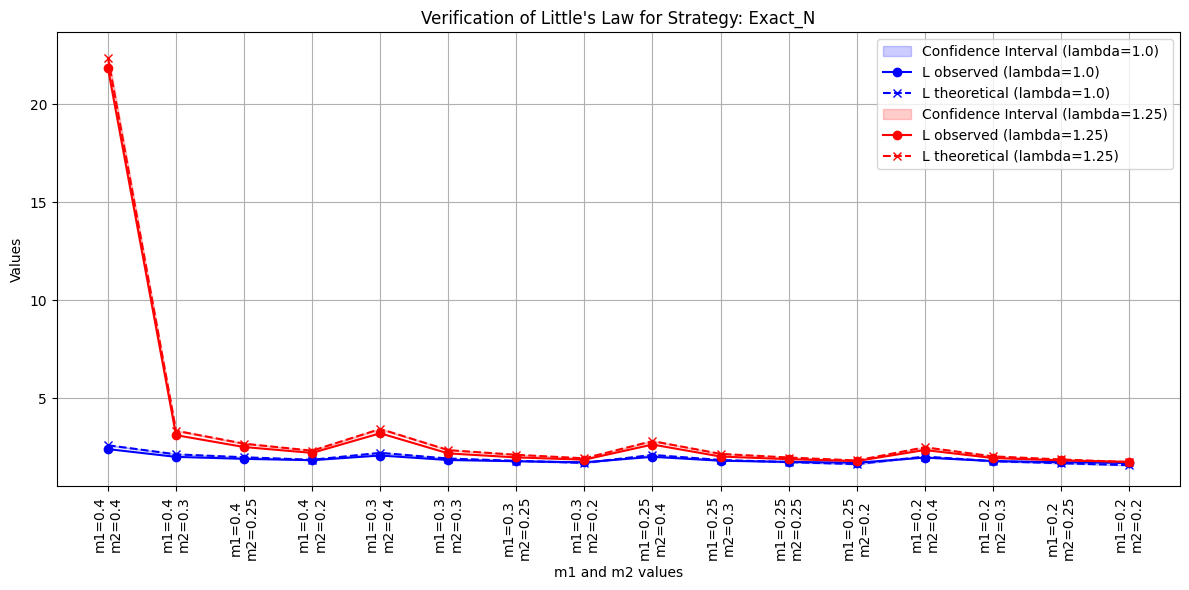

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


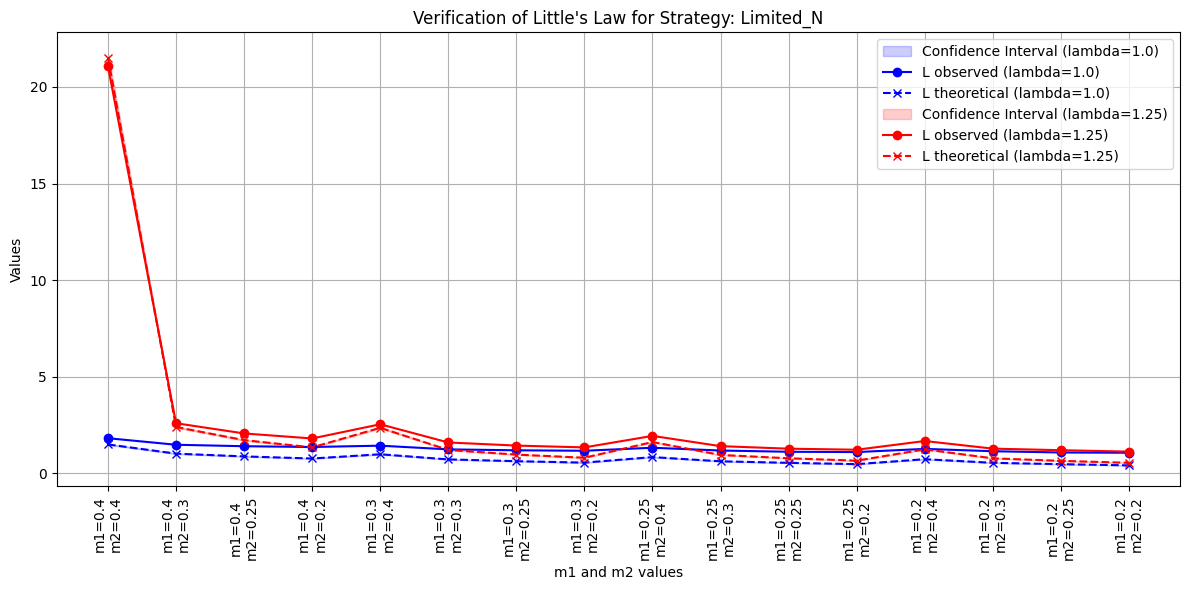

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


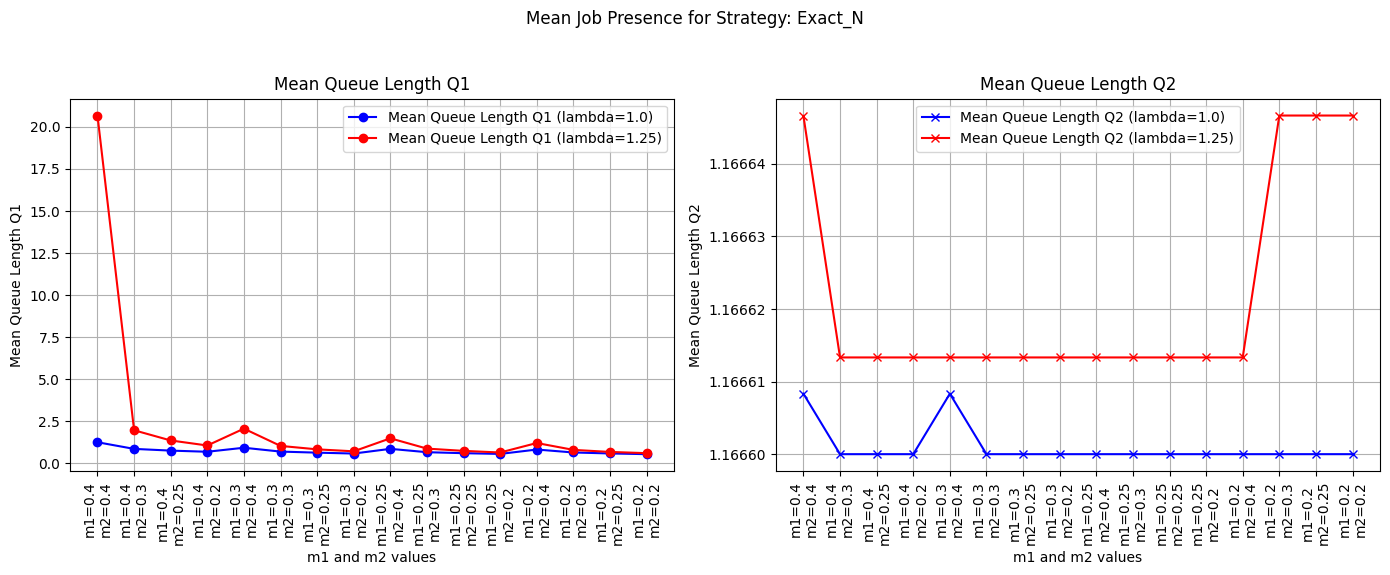

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


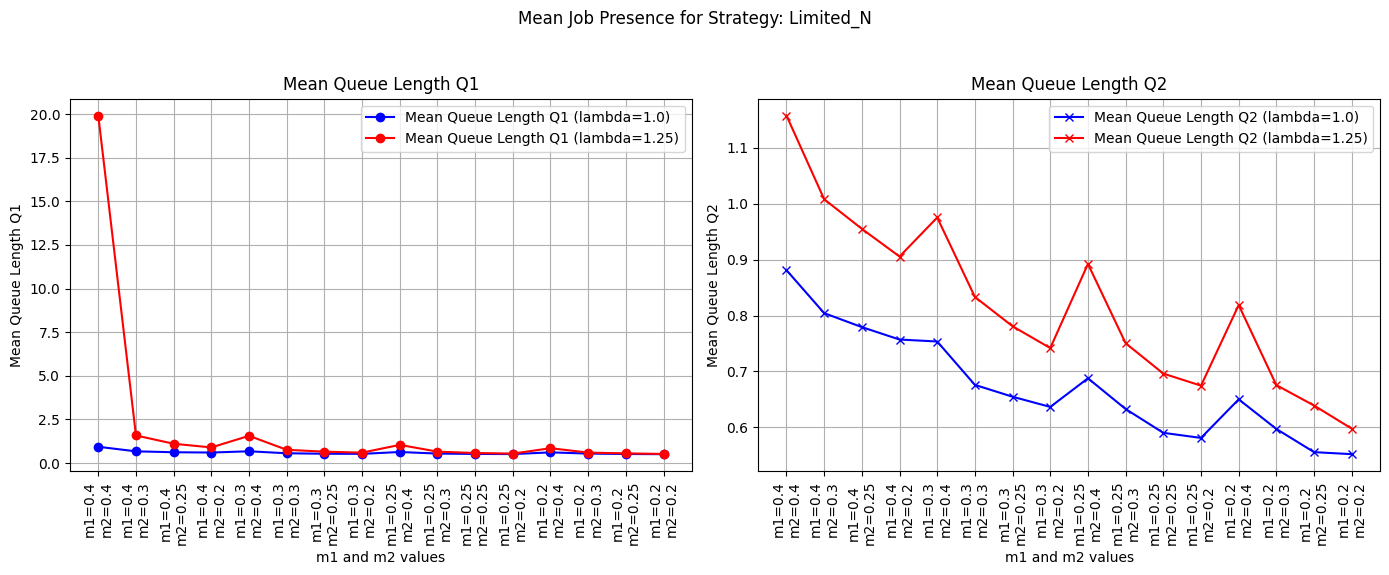

Utenti medi nel sistema per lambda=1.0: 1.5811872497600383
Utenti medi nel sistema per lambda=1.25: 3.1519607986132803
Presenza media in Q1: 1.4099733525585452
Presenza media in Q2: 0.9566006716281144
Presenza media in Q1 per lambda=1.0: 0.6606975371372756
Presenza media in Q2 per lambda=1.0: 0.9204897126227626
Presenza media in Q1 per lambda=1.25: 2.1592491679798145
Presenza media in Q2 per lambda=1.25: 0.992711630633466
Utenti medi nel sistema: 2.3665740241866597
Configurazioni che hanno passato il teorema di Little:
        File Strategy  lambda    m1    m2
52  Config53  Exact_N     1.0  0.25  0.25
58  Config59  Exact_N     1.0  0.20  0.30


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.ticker import ScalarFormatter

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Funzione per estrarre i valori di m1 e m2 dalla descrizione
def extract_m_values(description):
    match_m1 = re.search(r'm1=([\d\.]+)', description)
    match_m2 = re.search(r'm2=([\d\.]+)', description)
    if match_m1 and match_m2:
        return float(match_m1.group(1)), float(match_m2.group(1))
    else:
        return None, None

# Funzione per convertire la stringa di tempi in una lista di float
def convert_lifetime(lifetime_str):
    return list(map(float, lifetime_str.split(',')))

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation_2.csv')

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Estrai i valori di lambda, m1 e m2 dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)
results_df[['m1', 'm2']] = results_df['Description'].apply(lambda desc: pd.Series(extract_m_values(desc)))

# Converte le stringhe di lifetime in liste di float
results_df['lifeTime'] = results_df['lifeTime'].apply(convert_lifetime)

# Calcola le colonne L osservato e L teorico usando le medie delle lunghezze delle code
results_df['L_observed'] = results_df['mean_queueLength_Q1'] + results_df['mean_queueLength_Q2']
results_df['L_theoretical'] = results_df['lambda'] * results_df['mean_W']
results_df['L_theoretical_low'] = results_df['lambda'] * results_df['ci_low_W']
results_df['L_theoretical_high'] = results_df['lambda'] * results_df['ci_high_W']
results_df['L_difference'] = abs(results_df['L_observed'] - results_df['L_theoretical'])
results_df['percentage_L_difference'] = (results_df['L_difference'] / results_df['L_observed']) * 100

# Calcola L_low e L_max per il teorema di Little
results_df['little_verification'] = results_df.apply(lambda row: row['L_theoretical_low'] <= row['L_observed'] <= row['L_theoretical_high'], axis=1)

# Salva i risultati in un file CSV
results_df.to_csv('LittleLaw_results.csv', index=False)

# Mostra i risultati per debug
print(results_df[['File', 'Strategy', 'lambda', 'm1', 'm2', 'mean_W', 'ci_low_W', 'ci_high_W', 'L_observed', 'L_theoretical', 'L_theoretical_low', 'L_theoretical_high', 'L_difference', 'percentage_L_difference', 'little_verification']])

# Grafico per verificare il teorema di Little per tutte le configurazioni con politiche Limited_N ed Exact_N
strategies = ['Exact_N', 'Limited_N']
lambda_colors = {1.0: 'blue', 1.25: 'red'}

for strategy in strategies:
    subset = results_df[results_df['Strategy'] == strategy]
    if not subset.empty:
        plt.figure(figsize=(12, 6))
        for lambda_value, color in lambda_colors.items():
            subsubset = subset[subset['lambda'] == lambda_value]
            if not subsubset.empty:
                x_values = subsubset.apply(lambda row: f"m1={row['m1']}\nm2={row['m2']}", axis=1)
                plt.fill_between(np.arange(len(x_values)), subsubset['L_theoretical_low'], subsubset['L_theoretical_high'], color=color, alpha=0.2, label=f'Confidence Interval (lambda={lambda_value})')
                plt.plot(np.arange(len(x_values)), subsubset['L_observed'], marker='o', linestyle='-', color=color, label=f'L observed (lambda={lambda_value})')
                plt.plot(np.arange(len(x_values)), subsubset['L_theoretical'], marker='x', linestyle='--', color=color, label=f'L theoretical (lambda={lambda_value})')
        plt.xticks(np.arange(len(x_values)), x_values, rotation=90)
        plt.xlabel('m1 and m2 values')
        plt.ylabel('Values')
        plt.title(f'Verification of Little\'s Law for Strategy: {strategy}')
        plt.legend()
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        plt.tight_layout()
        plt.savefig(f'Convalidation_2_Images/LittleLaw_{strategy}.png')
        plt.savefig(f'Convalidation_2_Images/LittleLaw_{strategy}.eps')  
        plt.show()

# Grafico della presenza media di job nel sistema per le due code
for strategy in strategies:
    subset = results_df[results_df['Strategy'] == strategy]
    if not subset.empty:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        for lambda_value, color in lambda_colors.items():
            subsubset = subset[subset['lambda'] == lambda_value]
            if not subsubset.empty:
                x_values = subsubset.apply(lambda row: f"m1={row['m1']}\nm2={row['m2']}", axis=1)
                
                ax1.plot(np.arange(len(x_values)), subsubset['mean_queueLength_Q1'], marker='o', linestyle='-', color=color, label=f'Mean Queue Length Q1 (lambda={lambda_value})')
                ax1.set_xticks(np.arange(len(x_values)))
                ax1.set_xticklabels(x_values, rotation=90)
                ax1.set_xlabel('m1 and m2 values')
                ax1.set_ylabel('Mean Queue Length Q1')
                ax1.set_title('Mean Queue Length Q1')
                ax1.legend()
                ax1.grid(True)
                ax1.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
                
                ax2.plot(np.arange(len(x_values)), subsubset['mean_queueLength_Q2'], marker='x', linestyle='-', color=color, label=f'Mean Queue Length Q2 (lambda={lambda_value})')
                ax2.set_xticks(np.arange(len(x_values)))
                ax2.set_xticklabels(x_values, rotation=90)
                ax2.set_xlabel('m1 and m2 values')
                ax2.set_ylabel('Mean Queue Length Q2')
                ax2.set_title('Mean Queue Length Q2')
                ax2.legend()
                ax2.grid(True)
                ax2.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

        fig.suptitle(f'Mean Job Presence for Strategy: {strategy}')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
        plt.savefig(f'Convalidation_2_Images/Mean_Job_Presence_{strategy}.png')
        plt.savefig(f'Convalidation_2_Images/Mean_Job_Presence_{strategy}.eps')  
        plt.show()

# Calcolo degli utenti medi per lambda 1.0 e 1.25
mean_users_lambda_1_0 = results_df[results_df['lambda'] == 1.0]['L_observed'].mean()
mean_users_lambda_1_25 = results_df[results_df['lambda'] == 1.25]['L_observed'].mean()

print(f"Utenti medi nel sistema per lambda=1.0: {mean_users_lambda_1_0}")
print(f"Utenti medi nel sistema per lambda=1.25: {mean_users_lambda_1_25}")

# Calcolo della presenza media in Q1 e Q2 globalmente
mean_presence_Q1 = results_df['mean_queueLength_Q1'].mean()
mean_presence_Q2 = results_df['mean_queueLength_Q2'].mean()

# Calcolo della presenza media in Q1 e Q2 per lambda 1.0 e 1.25
mean_presence_Q1_lambda_1_0 = results_df[results_df['lambda'] == 1.0]['mean_queueLength_Q1'].mean()
mean_presence_Q2_lambda_1_0 = results_df[results_df['lambda'] == 1.0]['mean_queueLength_Q2'].mean()
mean_presence_Q1_lambda_1_25 = results_df[results_df['lambda'] == 1.25]['mean_queueLength_Q1'].mean()
mean_presence_Q2_lambda_1_25 = results_df[results_df['lambda'] == 1.25]['mean_queueLength_Q2'].mean()

print(f"Presenza media in Q1: {mean_presence_Q1}")
print(f"Presenza media in Q2: {mean_presence_Q2}")
print(f"Presenza media in Q1 per lambda=1.0: {mean_presence_Q1_lambda_1_0}")
print(f"Presenza media in Q2 per lambda=1.0: {mean_presence_Q2_lambda_1_0}")
print(f"Presenza media in Q1 per lambda=1.25: {mean_presence_Q1_lambda_1_25}")
print(f"Presenza media in Q2 per lambda=1.25: {mean_presence_Q2_lambda_1_25}")

# Calcola gli utenti medi nel sistema
mean_users = results_df['L_observed'].mean()
print(f"Utenti medi nel sistema: {mean_users}")

# Configurazioni che hanno passato il teorema di Little
little_law_passed = results_df[results_df['little_verification']]

print("Configurazioni che hanno passato il teorema di Little:")
print(little_law_passed[['File', 'Strategy', 'lambda', 'm1', 'm2']])
